In [1]:
#-----Importing Packages-----#
import os
import anndata as ad
import scipy
import numpy as np
import pandas as pd
import scanpy as sc
import scvelo as scv
import matplotlib.pyplot as plt
from scipy.io import mmread #Reading in mtx file 
from scipy.sparse import csr_matrix #convert from coo to csr matrix
from rich import print
import seaborn as sns
import palantir
import cellrank as cr

In [2]:
#------Loading in Data from Seurat------#
ConversionDirectory =  "/projects/b1217/HHA/Bulb_Recluster_5_22_AnnData/"
#Reading in the raw count matrix from seurat.combined
counts = mmread(os.path.join(ConversionDirectory, "HHA_SCRNA_Multiome_Matrix_FullConversion_RawCounts_5_30_25.mtx"))
counts = csr_matrix(counts.transpose()) #transposing to cell x gene matrix and converting to csr format
#Reading in the log normalized count matrix from seurat.combined
logcounts = mmread(os.path.join(ConversionDirectory, "HHA_SCRNA_Multiome_Matrix_FullConversion_Expression_LogCounts_5_30_25.mtx"))
logcounts = csr_matrix(logcounts.transpose()) #transposing to cell x gene matrix and converting to csr format
#Contains metadata, barcodes, and umap embeddings 
metadata = pd.read_csv(os.path.join(ConversionDirectory, "HHA_SCRNA_Multiome_Matrix_FullConversion_Metadata_5_30_25.csv"))
#Contains gene names 
gene_names = pd.read_csv(os.path.join(ConversionDirectory, "HHA_SCRNA_Multiome_Matrix_FullConversion_GeneNames_5_30_25.csv"))
#Converting to anndata object
Matrix = ad.AnnData(counts) #creating anndata object
Matrix.obs_names = metadata["barcode"] #Adding barcodes as obs names 
Matrix.var_names = gene_names["gene"] #adding gene names 
print(Matrix)
print(Matrix.obs_names[:10])
print(Matrix.var_names[:10])
scvi = pd.read_csv(os.path.join(ConversionDirectory, "HHA_SCRNA_Multiome_Matrix_FullConversion_scVI_Embeddings_5_30_25.csv"))
scvi["barcode"] = metadata["barcode"]
#------Adding metadata to anndata--------#
Matrix.obs = metadata
Matrix.obs_names = metadata["barcode"]
Matrix.obs["Likely_Ruptured_075"] = pd.Categorical(Matrix.obs["Likely_Ruptured_075"])

#-----Adding dimensionality reductions to obsm-----#
X_umap = metadata.set_index("barcode")[["UMAP_1", "UMAP_2"]]
Matrix.obsm['X_umap'] = X_umap.loc[Matrix.obs_names].values
X_scvi = scvi.set_index("barcode")
Matrix.obsm['X_scvi'] = X_scvi.loc[Matrix.obs_names].values
print(Matrix.obs.head())

AnnData object with n_obs × n_vars = 14780 × 48834

Index(['CAATACGGTAGTTACC-1_1', 'CCTCATGAGATGCTTC-1_1', 'TCTACCGAGCGTGAAC-1_1',
       'CATTCCGTCCGTGGCA-1_1', 'ATACTTCAGCCTCAGC-1_1', 'TCTCCGAGTATTTCCT-1_1',
       'CCACTTGAGTGGACGT-1_1', 'AACCAACGTACGGTTT-1_1', 'TTTACCAGTGCCCTTT-1_1',
       'TGCAGATTCGGACCAC-1_1'],
      dtype='object', name='barcode')

Index(['ENSG00000238009', 'ENSG00000241860', 'ENSG00000290385',
       'ENSG00000291215', 'LINC01409', 'ENSG00000290784', 'FAM87B',
       'LINC00115', 'LINC01128', 'ENSG00000288531'],
      dtype='object', name='gene')

orig.ident  nCount_RNA  nFeature_RNA  percent.mt  \
barcode                                                                 
CAATACGGTAGTTACC-1_1      EL_A5       62210          7082    4.155281   
CCTCATGAGATGCTTC-1_1      EL_A5       58667          7219    4.818723   
TCTACCGAGCGTGAAC-1_1      EL_A5       47534          5741    5.951529   
CATTCCGTCCGTGGCA-1_1      EL_A5       47018          6854    6.195500   
ATACTTCAGCCTCAGC-1_1      EL_A5       45017          7211    1.965924   

                      percent.ribo SampleID  DonorID Platform Isolation Sex  \
barcode                                                                       
CAATACGGTAGTTACC-1_1     13.549269    EL_A5        1     V3.1       FUE   M   
CCTCATGAGATGCTTC-1_1     13.378901    EL_A5        1     V3.1       FUE   M   
TCTACCGAGCGTGAAC-1_1     25.415492    EL_A5        1     V3.1       FUE   M   
CATTCCGTCCGTGGCA-1_1     20.619763    EL_A5        1     V3.1       FUE   M   
ATACTTCAGCCTCAGC-1_1     22.758069    EL_A5        1     V3.1       FUE   M   

                      ...  LPCCompAnnotation BulbAnnotationFine  \
barcode               ...                                         
CAATACGGTAGTTACC-1_1  ...                NaN        Late Cortex   
CCTCATGAGATGCTTC-1_1  ...                NaN        Late Cortex   
TCTACCGAGCGTGAAC-1_1  ...                NaN          IRS Henle   
CATTCCGTCCGTGGCA-1_1  ...                NaN         IRS Huxley   
ATACTTCAGCCTCAGC-1_1  ...                NaN        IRS Cuticle   

                      DownSampleRemoved MatrixAnnotationBroad  \
barcode                                                         
CAATACGGTAGTTACC-1_1              False                Cortex   
CCTCATGAGATGCTTC-1_1               True                Cortex   
TCTACCGAGCGTGAAC-1_1              False                   IRS   
CATTCCGTCCGTGGCA-1_1              False                   IRS   
ATACTTCAGCCTCAGC-1_1              False                   IRS   

                     MatrixAnnotationFine  FinalAnnotation  GeneralAnnotation  \
barcode                                                                         
CAATACGGTAGTTACC-1_1          Late_Cortex           Cortex               Bulb   
CCTCATGAGATGCTTC-1_1          Late_Cortex           Cortex               Bulb   
TCTACCGAGCGTGAAC-1_1           IRS_Huxley              IRS               Bulb   
CATTCCGTCCGTGGCA-1_1           IRS_Huxley              IRS               Bulb   
ATACTTCAGCCTCAGC-1_1          IRS_Cuticle              IRS               Bulb   

                        UMAP_1    UMAP_2               barcode  
barcode                                                         
CAATACGGTAGTTACC-1_1  8.438809 -1.382226  CAATACGGTAGTTACC-1_1  
CCTCATGAGATGCTTC-1_1  8.377587 -1.386279  CCTCATGAGATGCTTC-1_1  
TCTACCGAGCGTGAAC-1_1 -8.973949  0.033421  TCTACCGAGCGTGAAC-1_1  
CATTCCGTCCGTGGCA-1_1 -8.542003 -0.818430  CATTCCGTCCGTGGCA-1_1  
ATACTTCAGCCTCAGC-1_1 -6.222311 -3.448275  ATACTTCAGCCTCAGC-1_1  

[5 rows x 63 columns]

In [3]:
#-------Adding Log Normalized Counts to AnnData-----#
Matrix.layers["raw"] = Matrix.X.copy()
Matrix.layers["LogCounts"] = logcounts
Matrix.X = Matrix.layers["LogCounts"]

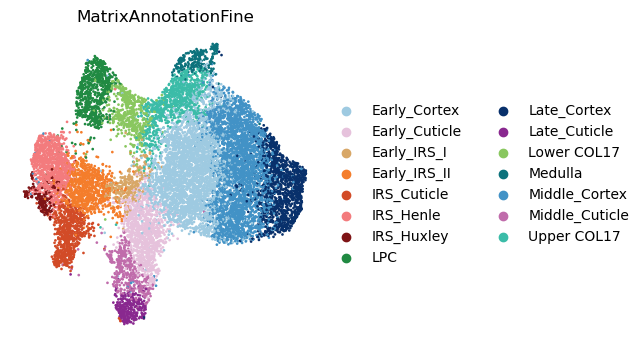

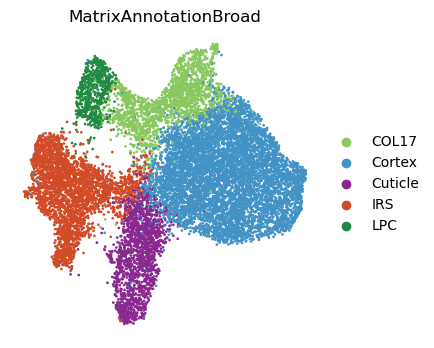

In [4]:
#--------Color Dictionaries------#
#Colors for Fine Annotation
fine_colors = {"Lower COL17": "#89C75F",
               "Upper COL17": "#3BBCA8",
               "LPC": "#208A42",
               "Medulla": "#0C727C",
               "Early_Cortex": "#9ECAE1",
               "Middle_Cortex": "#4292C6",
               "Late_Cortex": "#08306B",
               "Early_Cuticle": "#E6C2DC",
               "Middle_Cuticle": "#C06CAB",
               "Late_Cuticle": "#89288F",
               "Early_IRS_I": "#D8A767",
               "Early_IRS_II": "#F47D2B",
               "IRS_Henle": "#F37B7D",
               "IRS_Huxley": "#7E1416",
               "IRS_Cuticle": "#D24B27"}
#Colors for Broad Annotation
broad_colors = {"COL17": "#89C75F",
               "LPC": "#208A42",
               "Cortex": "#4292C6",
               "Cuticle": "#89288F",
               "IRS": "#D24B27"}

#--------Plotting UMAPs------#
#Fine Annotation
sc.pl.umap(Matrix, color="MatrixAnnotationFine", palette = fine_colors,
    frameon=False, size = 15)
#Broad Annotation
sc.pl.umap(Matrix, color="MatrixAnnotationBroad", palette = broad_colors,
           frameon = False, size = 15)

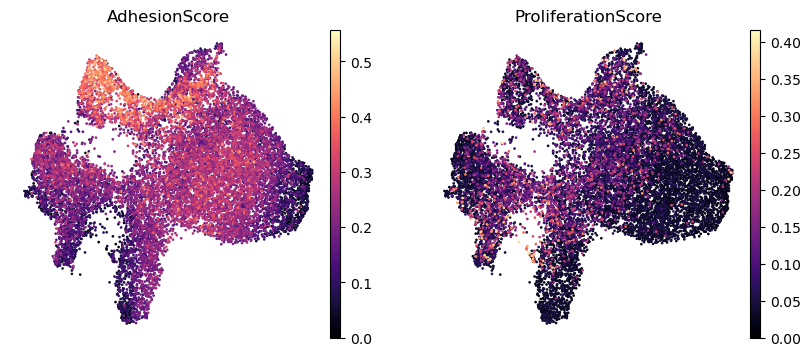

In [5]:
#------Adding Adhesion and Proliferation Scores to Seurat Object-------#
#Loading in AUCell scores for proliferation and adhesion from Seurat
Adhesion_Proliferation = pd.read_csv("/projects/b1217/HHA/Bulb_Seurat_Plots/Matrix_Adhesion_Proliferation_Scores.csv")
Adhesion_Proliferation = Adhesion_Proliferation.set_index("Barcode")
#Adding to obs
Matrix.obs["AdhesionScore"] = Adhesion_Proliferation["AdhesionScore"]
Matrix.obs["ProliferationScore"] = Adhesion_Proliferation["ProliferationScore"]
#Plotting on UMAP
sc.pl.umap(Matrix, color= ["AdhesionScore", "ProliferationScore"], ncols = 2,
    frameon=False, add_outline=False, size = 15, cmap = 'magma')

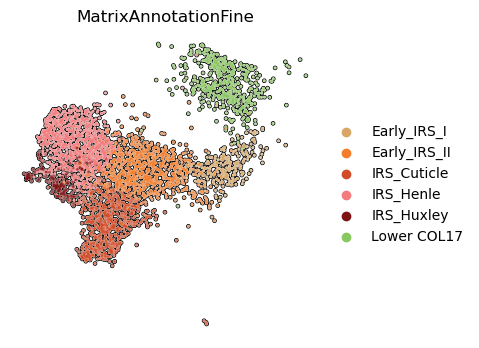

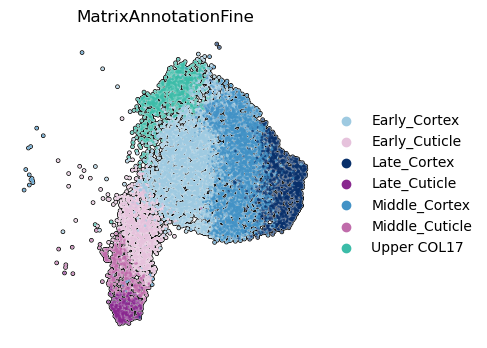

In [6]:
#------Subsetting to Lower and Upper Trajectories-------#
#Subsetting out IRS Lineage
Matrix_lower = Matrix[Matrix.obs["MatrixAnnotationFine"].isin(["Lower COL17",
                                                              "Early_IRS_I",
                                                              "Early_IRS_II",
                                                              "IRS_Cuticle",
                                                              "IRS_Huxley",
                                                              "IRS_Henle"]),:]
#Subsetting out Cortex/Cuticle Lineage
Matrix_upper = Matrix[Matrix.obs["MatrixAnnotationFine"].isin(["Upper COL17",
                                                              "Early_Cuticle",
                                                              "Middle_Cuticle",
                                                              "Late_Cuticle",
                                                              "Early_Cortex",
                                                              "Middle_Cortex",
                                                              "Late_Cortex"]),:]
#--------Checking Selection-----#
#Plotting IRS lineage
sc.pl.umap(
    Matrix_lower,
    color="MatrixAnnotationFine",
    frameon=False,
    add_outline=True,
    size = 15)
#Plotting Cortex/Cuticle lineages
sc.pl.umap(
    Matrix_upper,
    color="MatrixAnnotationFine",
    frameon=False,
    add_outline=True,
    size = 15)

In [7]:
#--------Run Diffusion Maps: Lower Trajectory------#
dm_res_lower = palantir.utils.run_diffusion_maps(Matrix_lower, n_components= 10, pca_key = "X_scvi")
#Using the top diffusion components 
n_comp = 5
opt_diffcomp_lower = palantir.utils.determine_multiscale_space(Matrix_lower, n_eigs = n_comp)
opt_diffcomp_lower
opt_diffcomp_lower.columns = ["Component 0", "Component 1", "Component 2", "Component 3"]
opt_diffcomp_lower["MatrixAnnotationFine"] = Matrix_lower.obs["MatrixAnnotationFine"]

/projects/b1217/Chris/condaenvs/TrajEnv/lib/python3.9/site-packages/palantir/utils.py:485: ImplicitModificationWarning: Setting element `.obsp['DM_Kernel']` of view, initializing view as actual.
  data.obsp[kernel_key] = res["kernel"]


-------------------------------------------

Plotting All Diffusion Components on UMAP

-------------------------------------------

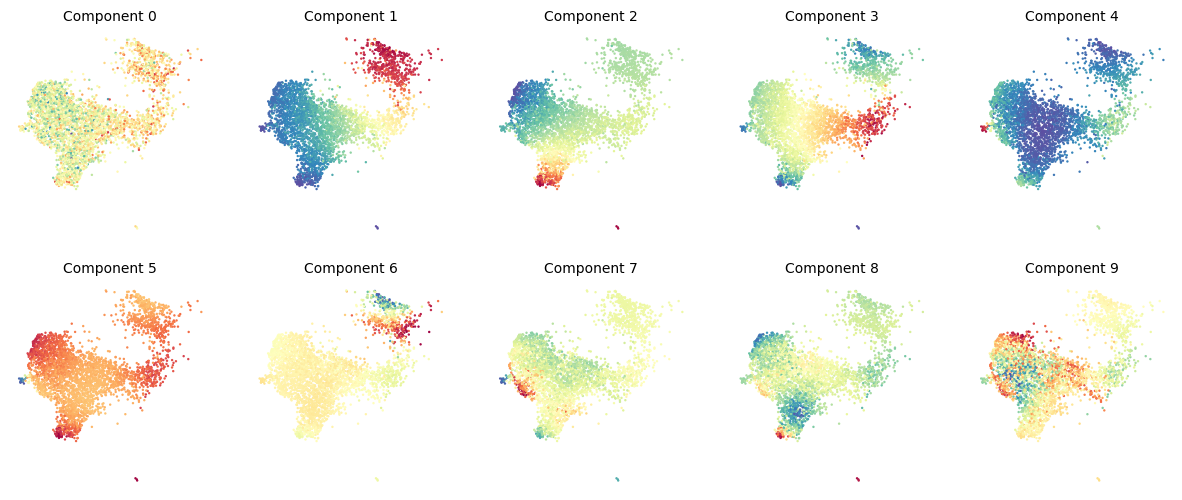

-------------------------------------------

Plotting Top 4 Diffusion Components

-------------------------------------------

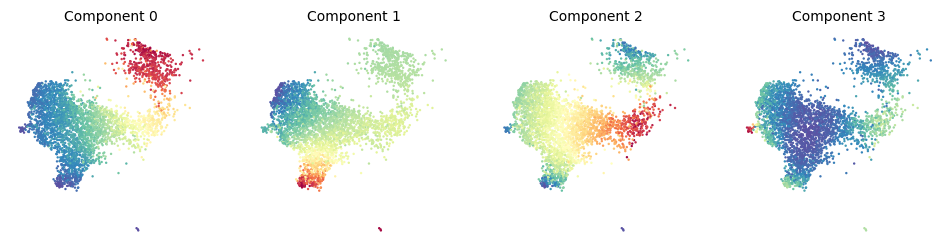

In [8]:
#------Plotting all and Selected Diffusion Components-----#
#Plotting all diffusion components 
print("-------------------------------------------")
print('  Plotting All Diffusion Components on UMAP'  )
print("-------------------------------------------")
palantir.plot.plot_diffusion_components(Matrix_lower, dm_res = "DM_EigenVectors", embedding_basis = "X_umap")
plt.show()
#Plotting top diffusion components
print("-------------------------------------------")
print(f'      Plotting Top {n_comp -1} Diffusion Components'    )
print("-------------------------------------------")
palantir.plot.plot_diffusion_components(Matrix_lower, dm_res = "DM_EigenVectors_multiscaled", embedding_basis = "X_umap")
plt.show()

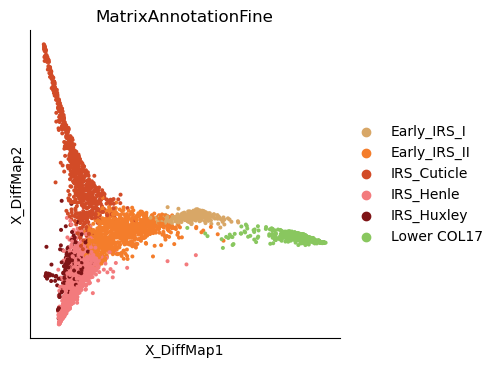

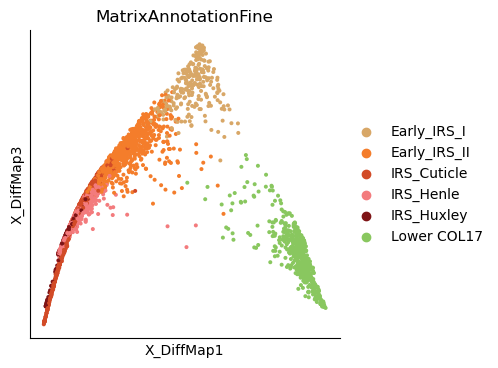

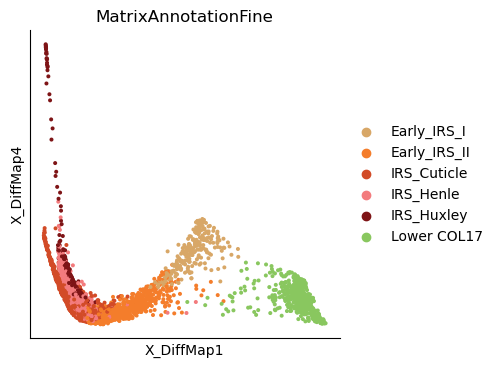

In [9]:
#-------Finding Root and Terminal Cells-------#
#Copying top components to new slot
Matrix_lower.obsm["X_DiffMap"] = Matrix_lower.obsm["DM_EigenVectors_multiscaled"]
#Plotting First 2 diffusion components
sc.pl.embedding(Matrix_lower, basis = "X_DiffMap", dimensions = [0,1], color = "MatrixAnnotationFine")
#Plotting 0 and 2
sc.pl.embedding(Matrix_lower, basis = "X_DiffMap", dimensions = [0,2], color = "MatrixAnnotationFine")
#Plotting 0 and 3
sc.pl.embedding(Matrix_lower, basis = "X_DiffMap", dimensions = [0, 3], color = "MatrixAnnotationFine")

TCTTGCGTCTGTAACG-1_5           Starting_Cell
AGCTAATTCCAGGGAA-1_8    IRS_Cuticle_Terminal
CATTGCTTCCTCTAAC-1_8      IRS_Henle_Terminal
CTACTATGTTTCTTAC-1_4     IRS_Huxley_Terminal
dtype: object

(<Figure size 600x600 with 1 Axes>, <Axes: >)

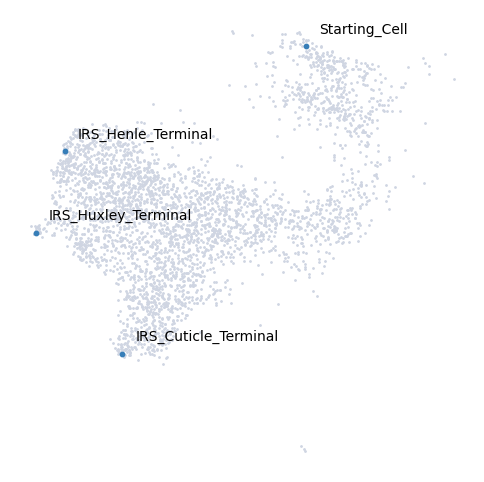

In [10]:
#--------Selecting Starting Cells from DC Extrema-------#
#Using component 3 extrema which maxes at lower COL17/ Huxley
starting_cell_lower = opt_diffcomp_lower["Component 0"].idxmax()

#-----Selecting Terminal Cells-------#
#Component 1 loosely corresponds to Cuticle versus Henle
IRS_Cuticle_terminal = opt_diffcomp_lower["Component 1"].idxmax()
IRS_Henle_terminal = opt_diffcomp_lower["Component 1"].idxmin()
#Component 3 loosely corresponds to IRS Huxley vs everything else
IRS_Huxley_terminal = opt_diffcomp_lower["Component 3"].idxmax()

#-------Putting in DF--------#
#Creating PD series storing starting cells
#starting_cells = pd.Series(["Lower_Start", "Upper_Start"],
#                           index = [lower_start2, upper_start2])
#Creating PD series storing terminal cells
terminal_cells_lower = pd.Series(['IRS_Cuticle_Terminal', 'IRS_Henle_Terminal', 'IRS_Huxley_Terminal'],
                           index = [IRS_Cuticle_terminal, IRS_Henle_terminal, IRS_Huxley_terminal])
#Creating PD series storing starting and terminal cells for plotting
start_end_cells_lower = pd.Series(["Starting_Cell", 'IRS_Cuticle_Terminal', 'IRS_Henle_Terminal', 'IRS_Huxley_Terminal'],
                           index = [starting_cell_lower, IRS_Cuticle_terminal, IRS_Henle_terminal, IRS_Huxley_terminal])
print(start_end_cells_lower)
#----Plotting on UMAP-----#
palantir.plot.highlight_cells_on_umap(Matrix_lower, start_end_cells_lower)

In [11]:
#------Running Palantir: Lower Pseudotime------#
#Using lower start cell as starting cell
lower_pr_res = palantir.core.run_palantir(Matrix_lower, starting_cell_lower, num_waypoints=500, 
                                    terminal_states=terminal_cells_lower, n_jobs = -1)

Sampling and flocking waypoints...
Time for determining waypoints: 0.001733080546061198 minutes
Determining pseudotime...
Shortest path distances using 30-nearest neighbor graph...
Time for shortest paths: 0.5563987414042155 minutes
Iteratively refining the pseudotime...
Correlation at iteration 1: 0.9997
Correlation at iteration 2: 1.0000
Entropy and branch probabilities...
Markov chain construction...
Computing fundamental matrix and absorption probabilities...
Project results to all cells...


-------------------------------------------

Plotting Palantir Results: Lower

-------------------------------------------

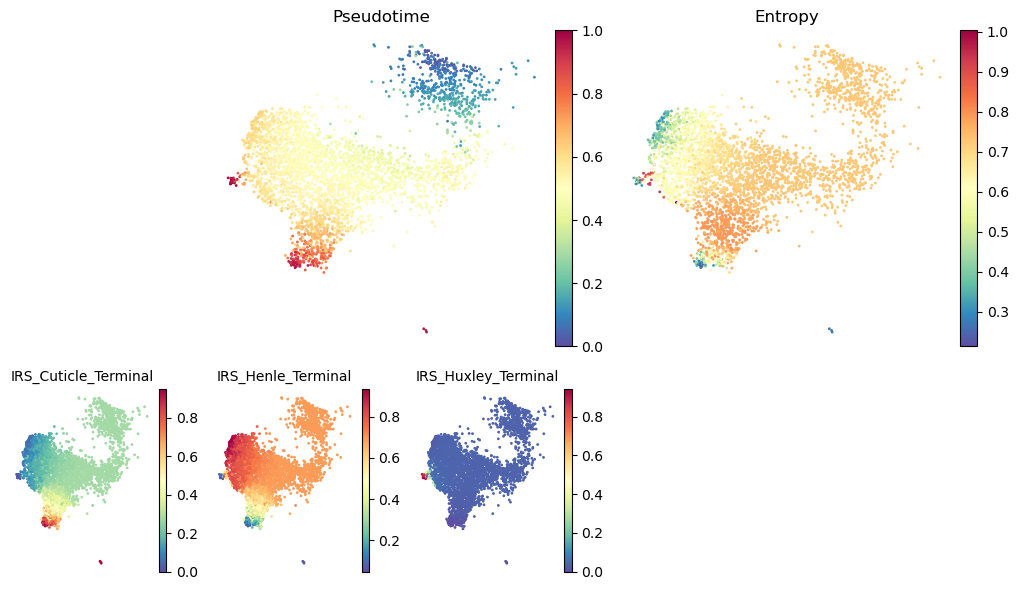

In [12]:
print("-------------------------------------------")
print('     Plotting Palantir Results: Lower'  )
print("-------------------------------------------")
palantir.plot.plot_palantir_results(Matrix_lower, s=1)
plt.show()

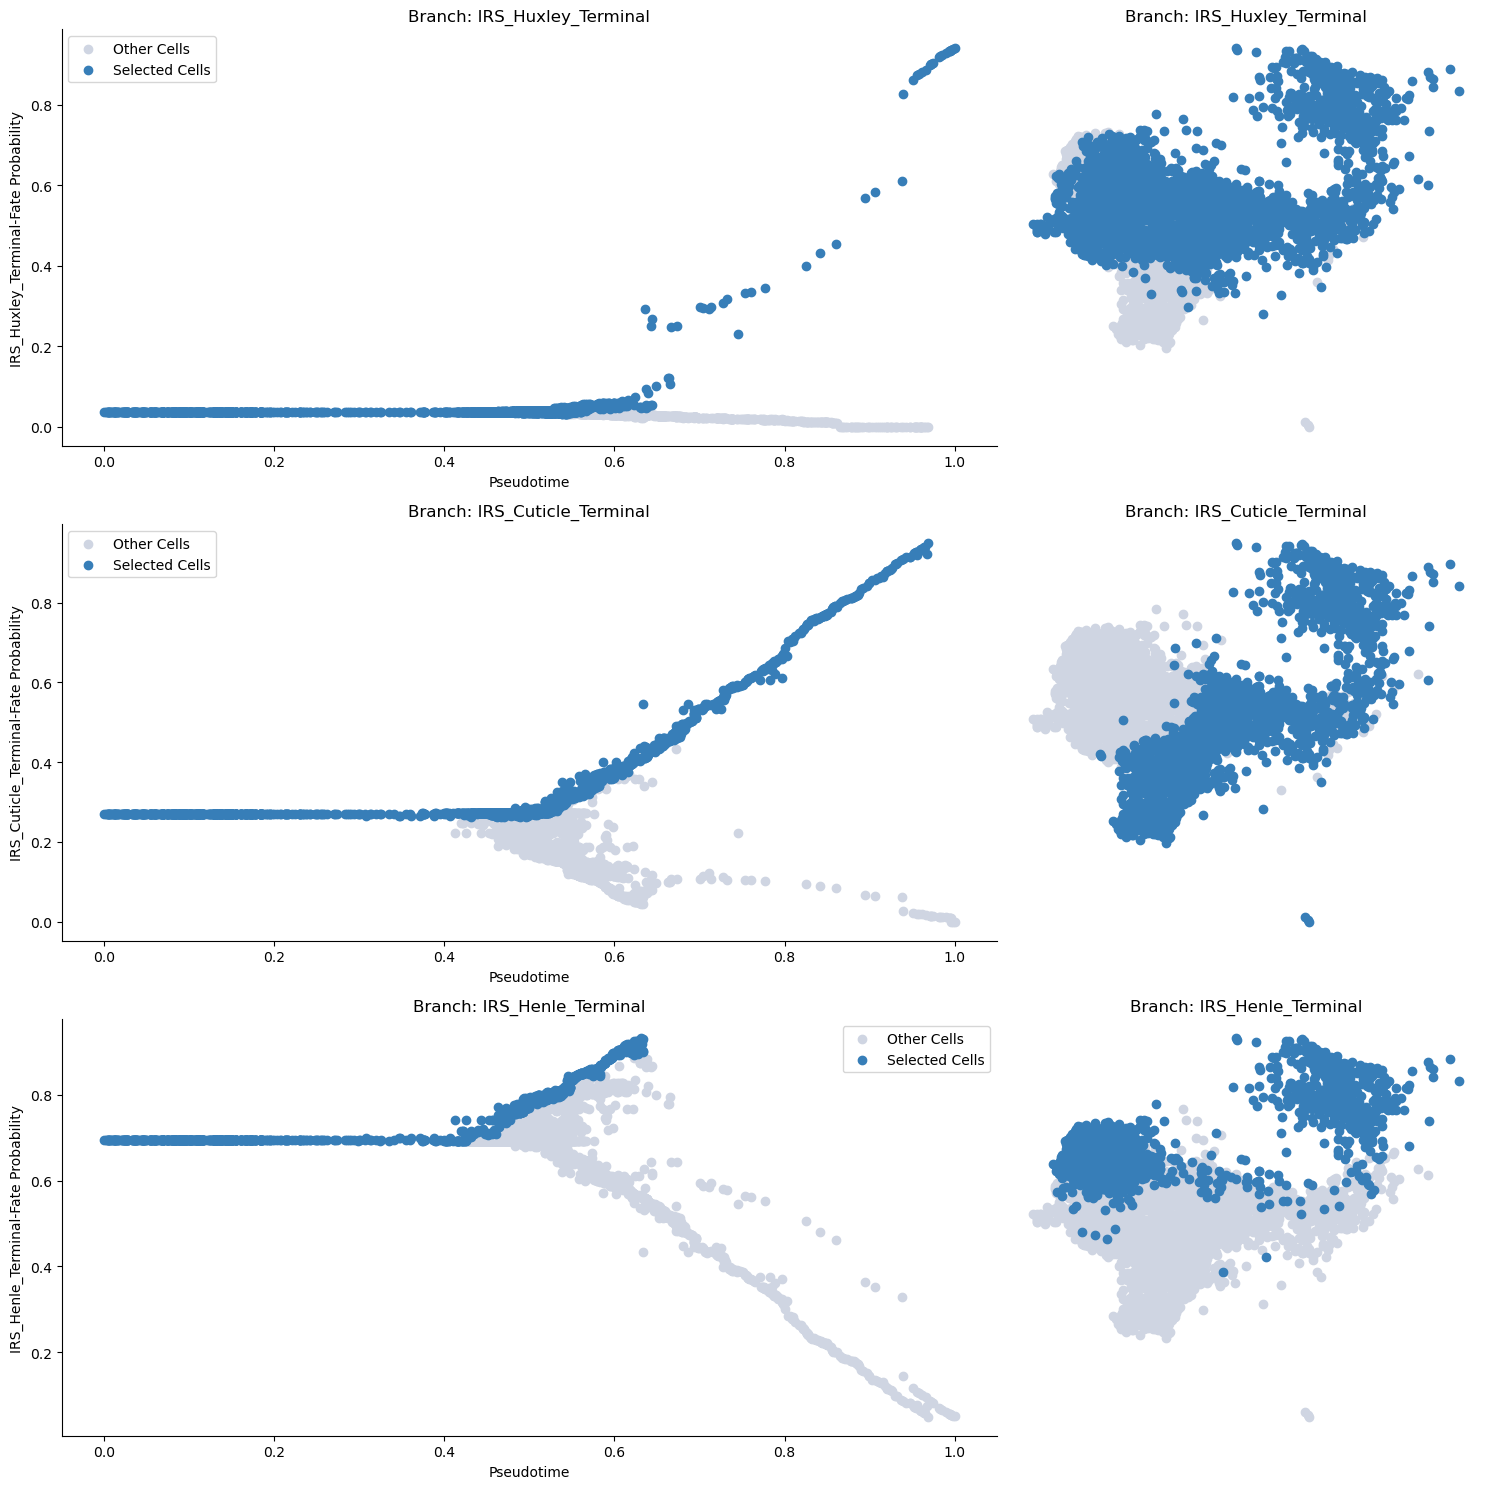

In [13]:
#-------Selecting Cells Mapping to Each Branch-----#
masks_lower = palantir.presults.select_branch_cells(Matrix_lower, q=.01, eps=.01)
palantir.plot.plot_branch_selection(Matrix_lower)
plt.show()

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


[2026-02-13 22:18:50,570] [INFO    ] Using sparse Gaussian Process since n_landmarks (50) < n_samples (1,995) and rank = 1.0.
[2026-02-13 22:18:50,570] [INFO    ] Using covariance function Matern52(ls=0.700789366567784).
[2026-02-13 22:18:50,588] [INFO    ] Computing 50 landmarks with k-means clustering (random_state=42).
[2026-02-13 22:18:51,278] [INFO    ] Sigma interpreted as element-wise standard deviation.
[2026-02-13 22:18:51,700] [INFO    ] Using sparse Gaussian Process since n_landmarks (50) < n_samples (1,208) and rank = 1.0.
[2026-02-13 22:18:51,701] [INFO    ] Using covariance function Matern52(ls=0.700789366567784).
[2026-02-13 22:18:51,717] [INFO    ] Computing 50 landmarks with k-means clustering (random_state=42).
[2026-02-13 22:18:51,989] [INFO    ] Sigma interpreted as element-wise standard deviation.
[2026-02-13 22:18:52,081] [INFO    ] Using sparse Gaussian Process since n_landmarks (50) < n_samples (2,787) and rank = 1.0.
[2026-02-13 22:18:52,082] [INFO    ] Using c

<Axes: title={'center': 'Branch: IRS_Huxley_Terminal'}, xlabel='UMAP1', ylabel='UMAP2'>

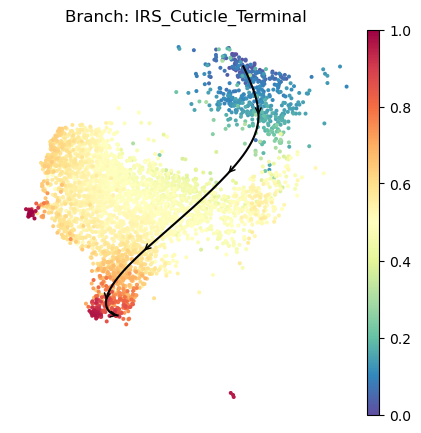

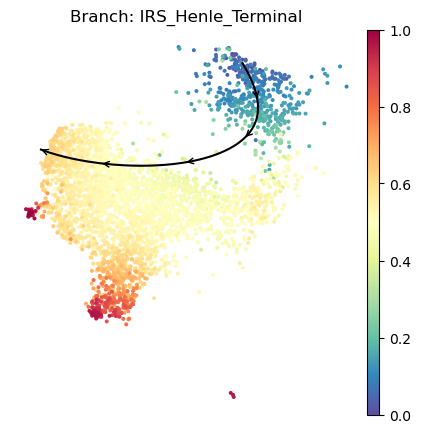

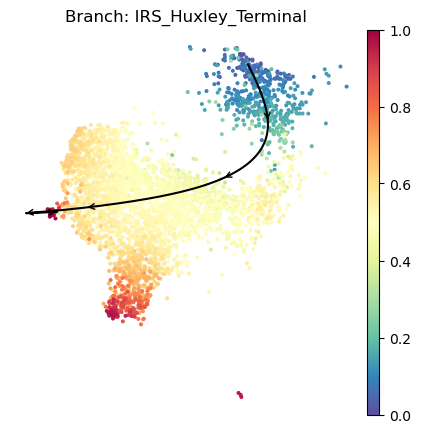

In [14]:
#--------Plotting IRS Trajectories-----#
palantir.plot.plot_trajectory(Matrix_lower, "IRS_Cuticle_Terminal", cell_color = "palantir_pseudotime")
palantir.plot.plot_trajectory(Matrix_lower, "IRS_Henle_Terminal", cell_color = "palantir_pseudotime")
palantir.plot.plot_trajectory(Matrix_lower, "IRS_Huxley_Terminal", cell_color = "palantir_pseudotime")

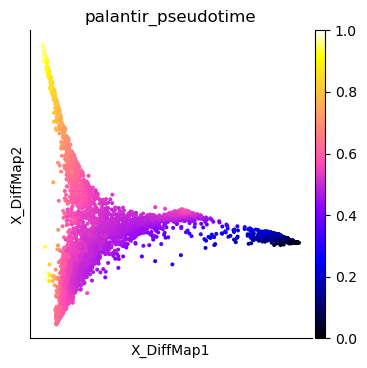

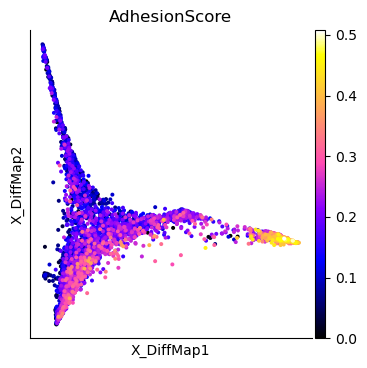

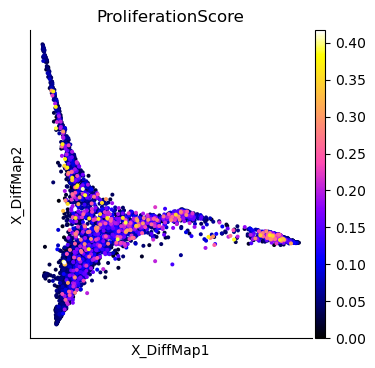

In [15]:
#---------Plotting Pseudotime on Diffusion Map-------#
sc.pl.embedding(Matrix_lower, basis = "X_DiffMap", 
                dimensions = [0,1], color = "palantir_pseudotime",
                cmap = "gnuplot2")
#Adhesion
sc.pl.embedding(Matrix_lower, basis = "X_DiffMap", 
                dimensions = [0,1], color = "AdhesionScore",
                cmap = "gnuplot2")
#Proliferation
sc.pl.embedding(Matrix_lower, basis = "X_DiffMap", 
                dimensions = [0,1], color = "ProliferationScore",
                cmap = "gnuplot2")

In [16]:
#--------Saving Pseudotime Results to csv--------#
#Retrieving Pseudotimes for IRS Lineages
IRS_Pseudotime = pd.DataFrame({"barcode": Matrix_lower.obs["barcode"],
                               "palantir_pseudotime_IRS": Matrix_lower.obs["palantir_pseudotime"],
                               "palantir_entropy_IRS": Matrix_lower.obs["palantir_entropy"]})
print(IRS_Pseudotime.head())
#Saving to csv
IRS_Pseudotime.to_csv(os.path.join(ConversionDirectory, "Palantir_IRS_Pseudotime.csv"), index = False)

#--------Saving Fate Probabilities to csv--------#
#Retrieving Fate Probabilities for IRS Lineages
IRS_FateProbs = Matrix_lower.obsm["palantir_fate_probabilities"]
IRS_FateProbs["barcode"] = Matrix_lower.obs["barcode"]
print(IRS_FateProbs.head())
#Saving Pseudotime Data to csv
IRS_FateProbs.to_csv(os.path.join(ConversionDirectory, "Palantir_IRS_FateProbs.csv"), index = False)

#-------Saving Branch Assignments to csv-------#
#Retrieving Branch Assignments for IRS Lineages
IRS_Branches = Matrix_lower.obsm["branch_masks"]
IRS_Branches["barcode"] = Matrix_lower.obs["barcode"]
print(IRS_Branches.head())
#Saving to csv
IRS_Branches.to_csv(os.path.join(ConversionDirectory, "Palantir_IRS_Branches.csv"), index = False)

barcode  palantir_pseudotime_IRS  \
barcode                                                               
TCTACCGAGCGTGAAC-1_1  TCTACCGAGCGTGAAC-1_1                 0.639593   
CATTCCGTCCGTGGCA-1_1  CATTCCGTCCGTGGCA-1_1                 0.602575   
ATACTTCAGCCTCAGC-1_1  ATACTTCAGCCTCAGC-1_1                 0.821512   
TCTCCGAGTATTTCCT-1_1  TCTCCGAGTATTTCCT-1_1                 0.592470   
TTTACCAGTGCCCTTT-1_1  TTTACCAGTGCCCTTT-1_1                 0.590078   

                      palantir_entropy_IRS  
barcode                                     
TCTACCGAGCGTGAAC-1_1              0.476914  
CATTCCGTCCGTGGCA-1_1              0.571977  
ATACTTCAGCCTCAGC-1_1              0.632474  
TCTCCGAGTATTTCCT-1_1              0.576180  
TTTACCAGTGCCCTTT-1_1              0.441581

IRS_Cuticle_Terminal  IRS_Henle_Terminal  \
barcode                                                          
TCTACCGAGCGTGAAC-1_1              0.079038            0.868770   
CATTCCGTCCGTGGCA-1_1              0.113301            0.827041   
ATACTTCAGCCTCAGC-1_1              0.733057            0.253837   
TCTCCGAGTATTTCCT-1_1              0.116531            0.824633   
TTTACCAGTGCCCTTT-1_1              0.088301            0.878370   

                      IRS_Huxley_Terminal               barcode  
barcode                                                          
TCTACCGAGCGTGAAC-1_1             0.052191  TCTACCGAGCGTGAAC-1_1  
CATTCCGTCCGTGGCA-1_1             0.059659  CATTCCGTCCGTGGCA-1_1  
ATACTTCAGCCTCAGC-1_1             0.013106  ATACTTCAGCCTCAGC-1_1  
TCTCCGAGTATTTCCT-1_1             0.058836  TCTCCGAGTATTTCCT-1_1  
TTTACCAGTGCCCTTT-1_1             0.033328  TTTACCAGTGCCCTTT-1_1

IRS_Cuticle_Terminal  IRS_Henle_Terminal  \
barcode                                                          
TCTACCGAGCGTGAAC-1_1                 False               False   
CATTCCGTCCGTGGCA-1_1                 False               False   
ATACTTCAGCCTCAGC-1_1                  True               False   
TCTCCGAGTATTTCCT-1_1                 False               False   
TTTACCAGTGCCCTTT-1_1                 False                True   

                      IRS_Huxley_Terminal               barcode  
barcode                                                          
TCTACCGAGCGTGAAC-1_1                 True  TCTACCGAGCGTGAAC-1_1  
CATTCCGTCCGTGGCA-1_1                 True  CATTCCGTCCGTGGCA-1_1  
ATACTTCAGCCTCAGC-1_1                False  ATACTTCAGCCTCAGC-1_1  
TCTCCGAGTATTTCCT-1_1                 True  TCTCCGAGTATTTCCT-1_1  
TTTACCAGTGCCCTTT-1_1                False  TTTACCAGTGCCCTTT-1_1

In [17]:
#---------Adding Pseudotimes to Matrix Object---------#
#Adding pseudotime data to new obs
new_obs = Matrix.obs.join(IRS_Pseudotime, how = "left", lsuffix = "L_", rsuffix = "R_")
new_obs.shape
#Replacing obs
Matrix.obs = new_obs
#Resetting barcode column
Matrix.obs["barcode"] = Matrix.obs_names
Matrix.obs = Matrix.obs.drop(["barcodeL_", "barcodeR_"], axis=1)
Matrix.obs

orig.ident  nCount_RNA  nFeature_RNA  percent.mt  \
barcode                                                                 
CAATACGGTAGTTACC-1_1      EL_A5       62210          7082    4.155281   
CCTCATGAGATGCTTC-1_1      EL_A5       58667          7219    4.818723   
TCTACCGAGCGTGAAC-1_1      EL_A5       47534          5741    5.951529   
CATTCCGTCCGTGGCA-1_1      EL_A5       47018          6854    6.195500   
ATACTTCAGCCTCAGC-1_1      EL_A5       45017          7211    1.965924   
...                         ...         ...           ...         ...   
ACACTTGCAGCAAGAT-1_5      EL_E8        1379           826   12.980421   
GAGCTAGCAGCCAGAA-1_5      EL_E8        1187           713   23.588880   
GACGCAACACACTAAT-1_5      EL_E8        1206           772   14.676617   
GTTAAACGTTGGATAT-1_5      EL_E8        1275           775   21.568627   
GATTAGTGTACAAAGA-1_5      EL_E8        1368           761   13.084795   

                      percent.ribo SampleID  DonorID  Platform Isolation Sex  \
barcode                                                                        
CAATACGGTAGTTACC-1_1     13.549269    EL_A5        1      V3.1       FUE   M   
CCTCATGAGATGCTTC-1_1     13.378901    EL_A5        1      V3.1       FUE   M   
TCTACCGAGCGTGAAC-1_1     25.415492    EL_A5        1      V3.1       FUE   M   
CATTCCGTCCGTGGCA-1_1     20.619763    EL_A5        1      V3.1       FUE   M   
ATACTTCAGCCTCAGC-1_1     22.758069    EL_A5        1      V3.1       FUE   M   
...                            ...      ...      ...       ...       ...  ..   
ACACTTGCAGCAAGAT-1_5      8.339376    EL_E8        5  Multiome      Bulb   M   
GAGCTAGCAGCCAGAA-1_5      8.171862    EL_E8        5  Multiome      Bulb   M   
GACGCAACACACTAAT-1_5     12.271973    EL_E8        5  Multiome      Bulb   M   
GTTAAACGTTGGATAT-1_5      2.588235    EL_E8        5  Multiome      Bulb   M   
GATTAGTGTACAAAGA-1_5      0.438596    EL_E8        5  Multiome      Bulb   M   

                      ...  MatrixAnnotationFine FinalAnnotation  \
barcode               ...                                         
CAATACGGTAGTTACC-1_1  ...           Late_Cortex          Cortex   
CCTCATGAGATGCTTC-1_1  ...           Late_Cortex          Cortex   
TCTACCGAGCGTGAAC-1_1  ...            IRS_Huxley             IRS   
CATTCCGTCCGTGGCA-1_1  ...            IRS_Huxley             IRS   
ATACTTCAGCCTCAGC-1_1  ...           IRS_Cuticle             IRS   
...                   ...                   ...             ...   
ACACTTGCAGCAAGAT-1_5  ...          Early_Cortex          Cortex   
GAGCTAGCAGCCAGAA-1_5  ...          Early_Cortex          Cortex   
GACGCAACACACTAAT-1_5  ...          Early_Cortex         Cuticle   
GTTAAACGTTGGATAT-1_5  ...          Early_Cortex          Cortex   
GATTAGTGTACAAAGA-1_5  ...           Late_Cortex          Cortex   

                      GeneralAnnotation    UMAP_1    UMAP_2  AdhesionScore  \
barcode                                                                      
CAATACGGTAGTTACC-1_1               Bulb  8.438809 -1.382226       0.032429   
CCTCATGAGATGCTTC-1_1               Bulb  8.377587 -1.386279       0.081184   
TCTACCGAGCGTGAAC-1_1               Bulb -8.973949  0.033421       0.050668   
CATTCCGTCCGTGGCA-1_1               Bulb -8.542003 -0.818430       0.079457   
ATACTTCAGCCTCAGC-1_1               Bulb -6.222311 -3.448275       0.085482   
...                                 ...       ...       ...            ...   
ACACTTGCAGCAAGAT-1_5               Bulb  1.425506  1.839127       0.065762   
GAGCTAGCAGCCAGAA-1_5               Bulb  0.394038  0.712035       0.104174   
GACGCAACACACTAAT-1_5               Bulb -0.057801 -0.477634       0.127925   
GTTAAACGTTGGATAT-1_5               Bulb  1.981708  0.309664       0.234855   
GATTAGTGTACAAAGA-1_5               Bulb  7.520019 -1.506932       0.050401   

                      ProliferationScore  palantir_pseudotime_IRS  \
barcode                                                             
CAATA

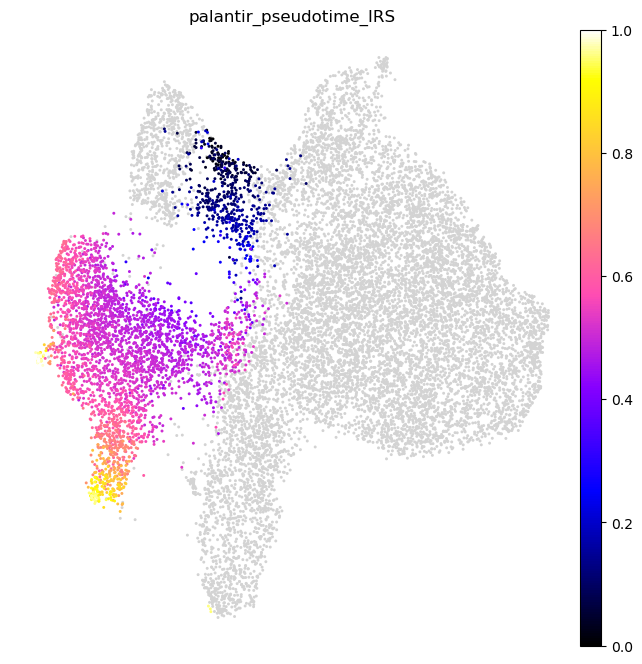

In [18]:
#---------Plotting Pseudotime on Diffusion Map-------#
fig,ax=plt.subplots(figsize=(8, 8))
sc.pl.embedding(Matrix, basis = "X_umap", 
                color = "palantir_pseudotime_IRS",
                frameon = False,
                cmap = "gnuplot2", 
                ax = ax,
                s = 18)
fig.savefig("/projects/b1217/HHA/Bulb_Seurat_Plots/Figure_6/Palantir/Matrix_IRS_Pseudotime_UMAP.png",
           dpi = 600, pad_inches = 0.5, bbox_inches = "tight")

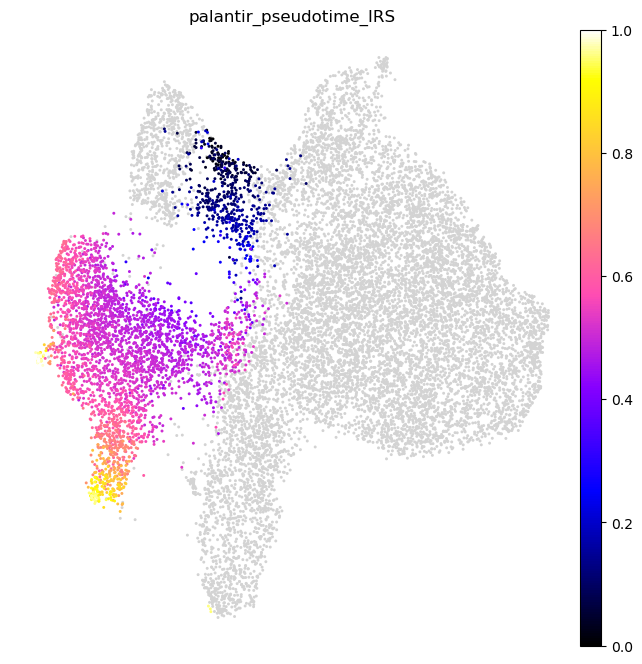

In [19]:
#---------Plotting Pseudotime on Diffusion Map-------#
fig,ax=plt.subplots(figsize=(8, 8))
sc.pl.embedding(Matrix, basis = "X_umap", 
                color = "palantir_pseudotime_IRS",
                frameon = False,
                cmap = "gnuplot2", 
                ax = ax,
                s = 18)
fig.savefig("/projects/b1217/HHA/Bulb_Seurat_Plots/Figure_6/Palantir/Matrix_IRS_Pseudotime_UMAP.png",
           dpi = 600, pad_inches = 0.5, bbox_inches = "tight")

In [20]:
#------Running Diffusion Maps: Upper Pseudotime------#
dm_res_upper = palantir.utils.run_diffusion_maps(Matrix_upper, n_components= 10, pca_key = "X_scvi")
#Using the top diffusion components 
n_comp = 3
opt_diffcomp_upper = palantir.utils.determine_multiscale_space(Matrix_upper, n_eigs = n_comp)
opt_diffcomp_upper
opt_diffcomp_upper.columns = ["Component 0", "Component 1"]
opt_diffcomp_upper["MatrixAnnotationFine"] = Matrix_upper.obs["MatrixAnnotationFine"]

/projects/b1217/Chris/condaenvs/TrajEnv/lib/python3.9/site-packages/palantir/utils.py:485: ImplicitModificationWarning: Setting element `.obsp['DM_Kernel']` of view, initializing view as actual.
  data.obsp[kernel_key] = res["kernel"]


-------------------------------------------

Plotting All Diffusion Components on UMAP

-------------------------------------------

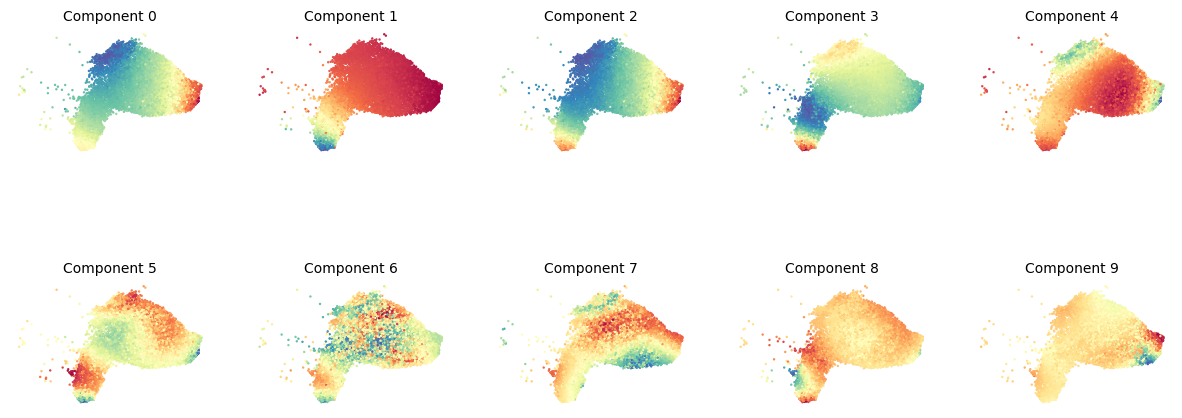

-------------------------------------------

Plotting Top 2 Diffusion Components

-------------------------------------------

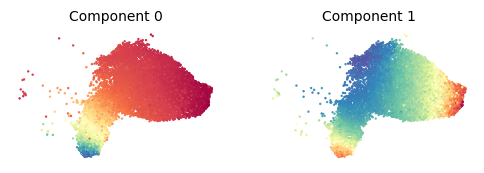

In [21]:
#------Plotting all and Selected Diffusion Components-----#
#Plotting all diffusion components 
print("-------------------------------------------")
print('  Plotting All Diffusion Components on UMAP'  )
print("-------------------------------------------")
palantir.plot.plot_diffusion_components(Matrix_upper, dm_res = "DM_EigenVectors", embedding_basis = "X_umap")
plt.show()
#Plotting top diffusion components
print("-------------------------------------------")
print(f'      Plotting Top {n_comp -1} Diffusion Components'    )
print("-------------------------------------------")
palantir.plot.plot_diffusion_components(Matrix_upper, dm_res = "DM_EigenVectors_multiscaled", embedding_basis = "X_umap")
plt.show()

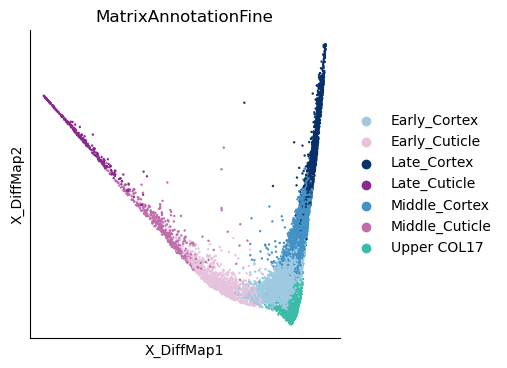

In [22]:
#-------Finding Root and Terminal Cells-------#
#Copying top components to new slot
Matrix_upper.obsm["X_DiffMap"] = Matrix_upper.obsm["DM_EigenVectors_multiscaled"]
#Plotting First 2 diffusion components
sc.pl.embedding(Matrix_upper, basis = "X_DiffMap", dimensions = [0,1], color = "MatrixAnnotationFine")

GCCGTGAGTTAGCTAC-1_4       Starting_Cell
GCTTCCATCATGAACT-1_8    Cuticle_Terminal
CCTCATGAGATGCTTC-1_1     Cortex_Terminal
dtype: object

(<Figure size 600x600 with 1 Axes>, <Axes: >)

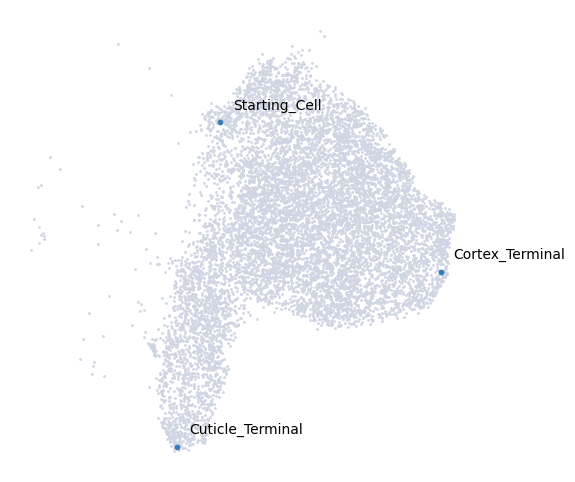

In [23]:
#--------Selecting Starting Cell from DC Extrema-------#
#Using component 1 extrema which corresponds to COl17 versus differentiated
starting_cell_upper = opt_diffcomp_upper["Component 1"].idxmin()

#-----Selecting Terminal Cells-------#
#Component 0 loosely corresponds to Cuticle vs all
Cuticle_terminal = opt_diffcomp_upper["Component 0"].idxmin()
#Component 1 loosely corresponds to Cortex versus Medulla
Cortex_terminal = opt_diffcomp_upper["Component 1"].idxmax()

#-------Putting in DF--------#
#Creating PD series storing terminal cells
terminal_cells_upper = pd.Series(['Cuticle_Terminal', 'Cortex_Terminal'],
                                 index = [Cuticle_terminal, Cortex_terminal])
#Creating PD series storing starting and terminal cells for plotting
start_end_cells_upper = pd.Series(["Starting_Cell", 'Cuticle_Terminal', 'Cortex_Terminal'],
                                  index = [starting_cell_upper, Cuticle_terminal, Cortex_terminal])
print(start_end_cells_upper)
#----Plotting on UMAP-----#
palantir.plot.highlight_cells_on_umap(Matrix_upper, start_end_cells_upper)

In [24]:
#------Running Palantir: Upper Pseudotime------#
#Using upper start cell as starting cell
upper_pr_res = palantir.core.run_palantir(Matrix_upper, starting_cell_upper, num_waypoints=500, 
                                    terminal_states= terminal_cells_upper, n_jobs = -1)

Sampling and flocking waypoints...
Time for determining waypoints: 0.007439235846201579 minutes
Determining pseudotime...
Shortest path distances using 30-nearest neighbor graph...
Time for shortest paths: 0.030944859981536864 minutes
Iteratively refining the pseudotime...
Correlation at iteration 1: 0.9999
Correlation at iteration 2: 1.0000
Entropy and branch probabilities...
Markov chain construction...
Computing fundamental matrix and absorption probabilities...
Project results to all cells...


-------------------------------------------

Plotting Palantir Results: Upper

-------------------------------------------

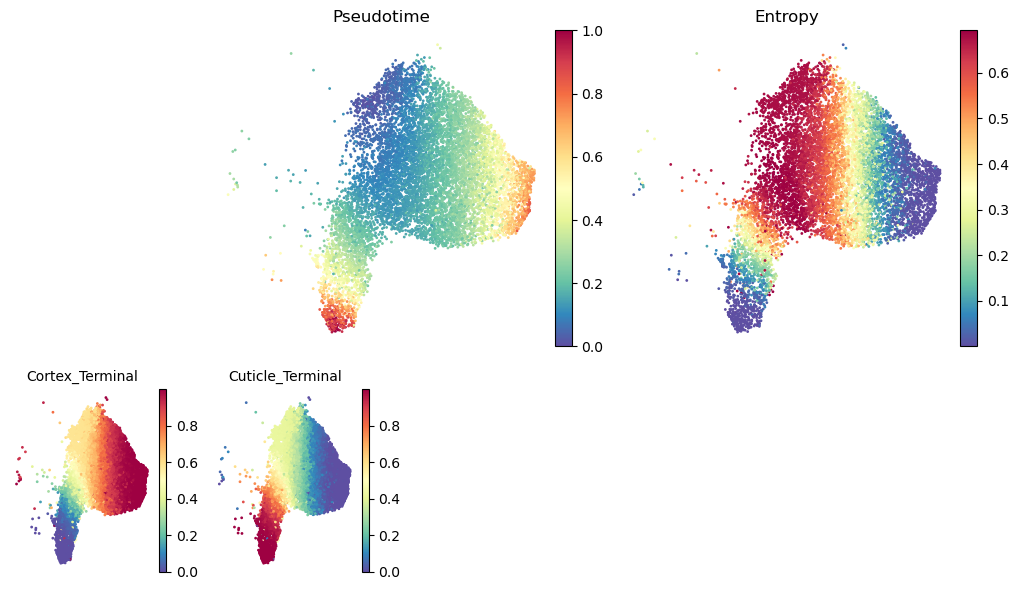

In [25]:
print("-------------------------------------------")
print('     Plotting Palantir Results: Upper'  )
print("-------------------------------------------")
palantir.plot.plot_palantir_results(Matrix_upper, s=1)
plt.show()

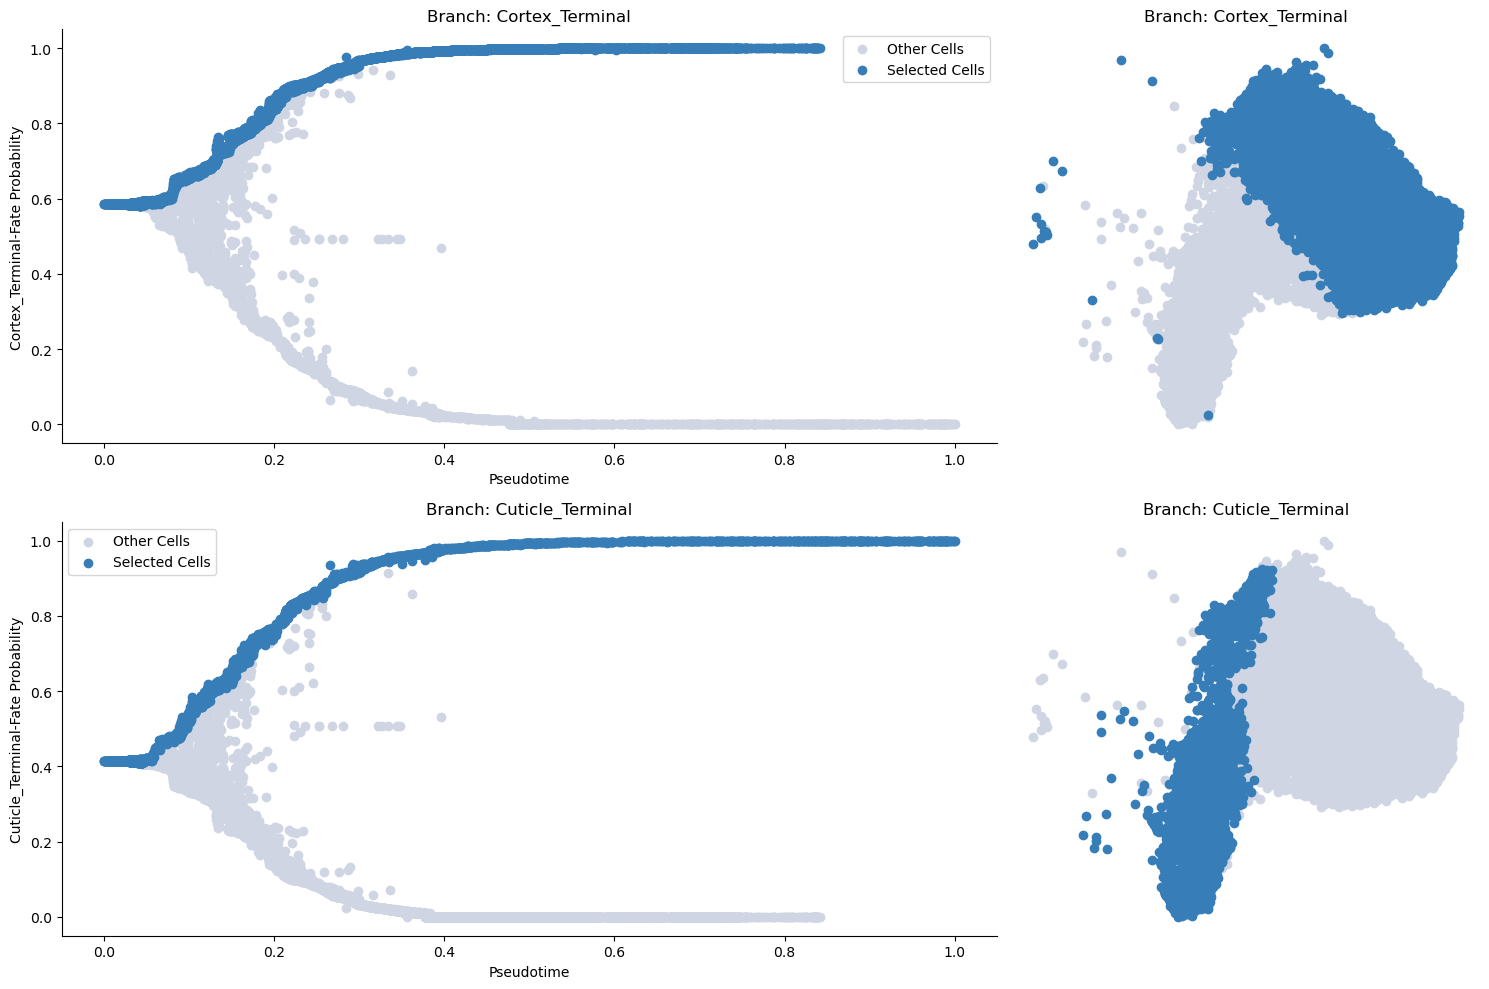

In [26]:
#-------Selecting Cells Mapping to Each Branch-----#
upper_masks = palantir.presults.select_branch_cells(Matrix_upper, q=.01, eps=.01)
palantir.plot.plot_branch_selection(Matrix_upper)
plt.show()

[2026-02-13 22:22:14,070] [INFO    ] Using sparse Gaussian Process since n_landmarks (50) < n_samples (2,370) and rank = 1.0.
[2026-02-13 22:22:14,071] [INFO    ] Using covariance function Matern52(ls=1.0625449934823634).
[2026-02-13 22:22:14,088] [INFO    ] Computing 50 landmarks with k-means clustering (random_state=42).
[2026-02-13 22:22:14,404] [INFO    ] Sigma interpreted as element-wise standard deviation.
[2026-02-13 22:22:14,499] [INFO    ] Using sparse Gaussian Process since n_landmarks (50) < n_samples (5,988) and rank = 1.0.
[2026-02-13 22:22:14,500] [INFO    ] Using covariance function Matern52(ls=1.0625449934823634).
[2026-02-13 22:22:14,516] [INFO    ] Computing 50 landmarks with k-means clustering (random_state=42).
[2026-02-13 22:22:14,854] [INFO    ] Sigma interpreted as element-wise standard deviation.


<Axes: title={'center': 'Branch: Cortex_Terminal'}, xlabel='UMAP1', ylabel='UMAP2'>

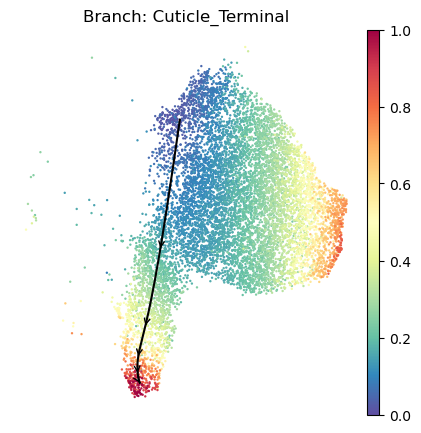

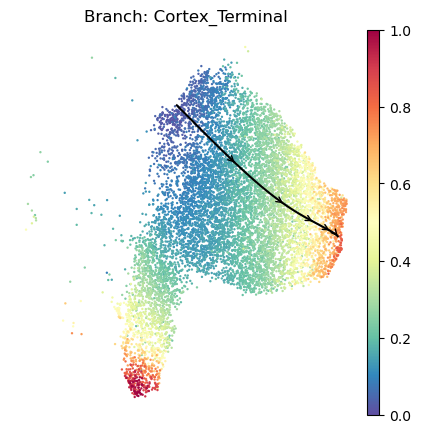

In [27]:
#--------Plotting Cortex/Cuticle Trajectories-----#
palantir.plot.plot_trajectory(Matrix_upper, "Cuticle_Terminal", cell_color = "palantir_pseudotime")
palantir.plot.plot_trajectory(Matrix_upper, "Cortex_Terminal", cell_color = "palantir_pseudotime")

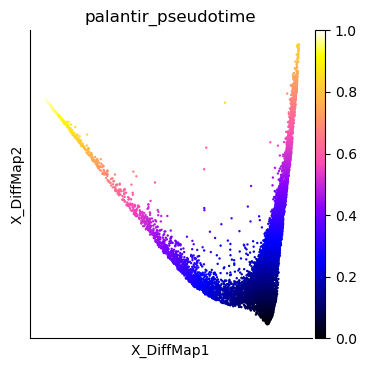

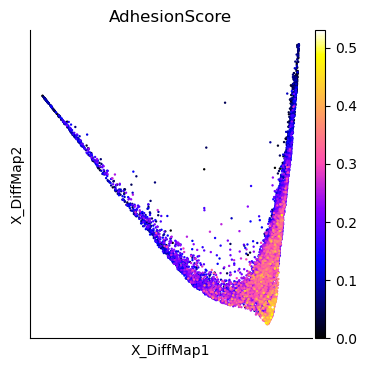

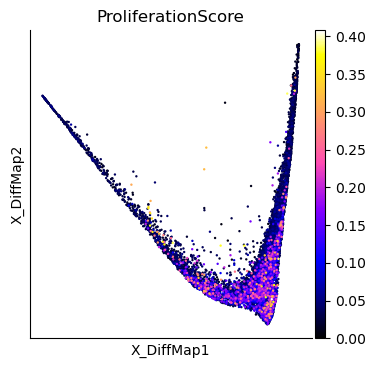

In [28]:
#---------Plotting Pseudotime on Diffusion Map-------#
#Pseudotime
sc.pl.embedding(Matrix_upper, basis = "X_DiffMap", 
                dimensions = [0,1], color = "palantir_pseudotime",
                cmap = "gnuplot2")
#Adhesion
sc.pl.embedding(Matrix_upper, basis = "X_DiffMap", 
                dimensions = [0,1], color = "AdhesionScore",
                cmap = "gnuplot2")
#Differentiation
sc.pl.embedding(Matrix_upper, basis = "X_DiffMap", 
                dimensions = [0,1], color = "ProliferationScore",
                cmap = "gnuplot2")

In [29]:
#--------Saving Results to csv--------#
#Retrieving Pseudotime for Cortex/Cuticle Lineages
CoCu_Pseudotime = pd.DataFrame({"barcode": Matrix_upper.obs["barcode"],
                               "palantir_pseudotime_CoCu": Matrix_upper.obs["palantir_pseudotime"],
                               "palantir_entropy_CoCu": Matrix_upper.obs["palantir_entropy"]})
print(CoCu_Pseudotime.head())
#Saving as csv
CoCu_Pseudotime.to_csv(os.path.join(ConversionDirectory, "Palantir_Cortex_Cuticle_Pseudotime.csv"))

#--------Saving Fate Probabilities to csv--------#
#Retrieving Fate Probabilities for Cortex/Cuticle Lineages
CoCu_FateProbs = Matrix_upper.obsm["palantir_fate_probabilities"]
CoCu_FateProbs["barcode"] = Matrix_upper.obs["barcode"]
print(CoCu_FateProbs.head())
#Saving to csv
CoCu_FateProbs.to_csv(os.path.join(ConversionDirectory, "Palantir_Cortex_Cuticle_FateProbs.csv"))

#-------Saving Branch Assignments to csv-------#
#Retrieving Branch Assignments for IRS Lineages
CoCu_Branches = Matrix_upper.obsm["branch_masks"]
CoCu_Branches["barcode"] = Matrix_upper.obs["barcode"]
print(CoCu_Branches.head())
#Saving to csv
CoCu_Branches.to_csv(os.path.join(ConversionDirectory, "Palantir_Cortex_Cuticle_Branches.csv"))

barcode  palantir_pseudotime_CoCu  \
barcode                                                                
CAATACGGTAGTTACC-1_1  CAATACGGTAGTTACC-1_1                  0.834177   
CCTCATGAGATGCTTC-1_1  CCTCATGAGATGCTTC-1_1                  0.839393   
AACCAACGTACGGTTT-1_1  AACCAACGTACGGTTT-1_1                  0.166626   
ATTACCTCAAGAAATC-1_1  ATTACCTCAAGAAATC-1_1                  0.843654   
TCCAGAACAAACTCGT-1_1  TCCAGAACAAACTCGT-1_1                  0.122069   

                      palantir_entropy_CoCu  
barcode                                      
CAATACGGTAGTTACC-1_1               0.000035  
CCTCATGAGATGCTTC-1_1               0.000033  
AACCAACGTACGGTTT-1_1               0.517553  
ATTACCTCAAGAAATC-1_1               0.000423  
TCCAGAACAAACTCGT-1_1               0.625246

Cortex_Terminal  Cuticle_Terminal               barcode
barcode                                                                      
CAATACGGTAGTTACC-1_1         0.999997          0.000000  CAATACGGTAGTTACC-1_1
CCTCATGAGATGCTTC-1_1         0.999998          0.000000  CCTCATGAGATGCTTC-1_1
AACCAACGTACGGTTT-1_1         0.787268          0.212732  AACCAACGTACGGTTT-1_1
ATTACCTCAAGAAATC-1_1         0.000000          0.999962  ATTACCTCAAGAAATC-1_1
TCCAGAACAAACTCGT-1_1         0.682139          0.317861  TCCAGAACAAACTCGT-1_1

Cortex_Terminal  Cuticle_Terminal               barcode
barcode                                                                      
CAATACGGTAGTTACC-1_1             True             False  CAATACGGTAGTTACC-1_1
CCTCATGAGATGCTTC-1_1             True             False  CCTCATGAGATGCTTC-1_1
AACCAACGTACGGTTT-1_1             True             False  AACCAACGTACGGTTT-1_1
ATTACCTCAAGAAATC-1_1            False              True  ATTACCTCAAGAAATC-1_1
TCCAGAACAAACTCGT-1_1             True             False  TCCAGAACAAACTCGT-1_1

In [30]:
#---------Adding Pseudotimes to Matrix Object---------#
#Adding pseudotime data to new obs
new_obs = Matrix.obs.join(CoCu_Pseudotime, how = "left", lsuffix = "L_", rsuffix = "R_")
new_obs.shape
#Replacing obs
Matrix.obs = new_obs
#Resetting barcode column
Matrix.obs["barcode"] = Matrix.obs_names
Matrix.obs = Matrix.obs.drop(["barcodeL_", "barcodeR_"], axis=1)
Matrix.obs

orig.ident  nCount_RNA  nFeature_RNA  percent.mt  \
barcode                                                                 
CAATACGGTAGTTACC-1_1      EL_A5       62210          7082    4.155281   
CCTCATGAGATGCTTC-1_1      EL_A5       58667          7219    4.818723   
TCTACCGAGCGTGAAC-1_1      EL_A5       47534          5741    5.951529   
CATTCCGTCCGTGGCA-1_1      EL_A5       47018          6854    6.195500   
ATACTTCAGCCTCAGC-1_1      EL_A5       45017          7211    1.965924   
...                         ...         ...           ...         ...   
ACACTTGCAGCAAGAT-1_5      EL_E8        1379           826   12.980421   
GAGCTAGCAGCCAGAA-1_5      EL_E8        1187           713   23.588880   
GACGCAACACACTAAT-1_5      EL_E8        1206           772   14.676617   
GTTAAACGTTGGATAT-1_5      EL_E8        1275           775   21.568627   
GATTAGTGTACAAAGA-1_5      EL_E8        1368           761   13.084795   

                      percent.ribo SampleID  DonorID  Platform Isolation Sex  \
barcode                                                                        
CAATACGGTAGTTACC-1_1     13.549269    EL_A5        1      V3.1       FUE   M   
CCTCATGAGATGCTTC-1_1     13.378901    EL_A5        1      V3.1       FUE   M   
TCTACCGAGCGTGAAC-1_1     25.415492    EL_A5        1      V3.1       FUE   M   
CATTCCGTCCGTGGCA-1_1     20.619763    EL_A5        1      V3.1       FUE   M   
ATACTTCAGCCTCAGC-1_1     22.758069    EL_A5        1      V3.1       FUE   M   
...                            ...      ...      ...       ...       ...  ..   
ACACTTGCAGCAAGAT-1_5      8.339376    EL_E8        5  Multiome      Bulb   M   
GAGCTAGCAGCCAGAA-1_5      8.171862    EL_E8        5  Multiome      Bulb   M   
GACGCAACACACTAAT-1_5     12.271973    EL_E8        5  Multiome      Bulb   M   
GTTAAACGTTGGATAT-1_5      2.588235    EL_E8        5  Multiome      Bulb   M   
GATTAGTGTACAAAGA-1_5      0.438596    EL_E8        5  Multiome      Bulb   M   

                      ...  GeneralAnnotation    UMAP_1    UMAP_2  \
barcode               ...                                          
CAATACGGTAGTTACC-1_1  ...               Bulb  8.438809 -1.382226   
CCTCATGAGATGCTTC-1_1  ...               Bulb  8.377587 -1.386279   
TCTACCGAGCGTGAAC-1_1  ...               Bulb -8.973949  0.033421   
CATTCCGTCCGTGGCA-1_1  ...               Bulb -8.542003 -0.818430   
ATACTTCAGCCTCAGC-1_1  ...               Bulb -6.222311 -3.448275   
...                   ...                ...       ...       ...   
ACACTTGCAGCAAGAT-1_5  ...               Bulb  1.425506  1.839127   
GAGCTAGCAGCCAGAA-1_5  ...               Bulb  0.394038  0.712035   
GACGCAACACACTAAT-1_5  ...               Bulb -0.057801 -0.477634   
GTTAAACGTTGGATAT-1_5  ...               Bulb  1.981708  0.309664   
GATTAGTGTACAAAGA-1_5  ...               Bulb  7.520019 -1.506932   

                     AdhesionScore ProliferationScore  \
barcode                                                 
CAATACGGTAGTTACC-1_1      0.032429           0.013230   
CCTCATGAGATGCTTC-1_1      0.081184           0.012472   
TCTACCGAGCGTGAAC-1_1      0.050668           0.016117   
CATTCCGTCCGTGGCA-1_1      0.079457           0.029157   
ATACTTCAGCCTCAGC-1_1      0.085482           0.043675   
...                            ...                ...   
ACACTTGCAGCAAGAT-1_5      0.065762           0.085567   
GAGCTAGCAGCCAGAA-1_5      0.104174           0.033754   
GACGCAACACACTAAT-1_5      0.127925           0.083547   
GTTAAACGTTGGATAT-1_5      0.234855           0.035184   
GATTAGTGTACAAAGA-1_5      0.050401           0.038041   

                      palantir_pseudotime_IRS  palantir_entropy_IRS  \
barcode                                                               
CAATACGGTAGTTACC-1_1                      NaN                   NaN   
CCTCATGAGATGCTTC-1_1                      NaN                   NaN   
TCTACCGAGCGTGAAC-1_1                 0.639593              0.476914   
CATTCCGTCCGTGGCA-1_1                 0.602575   

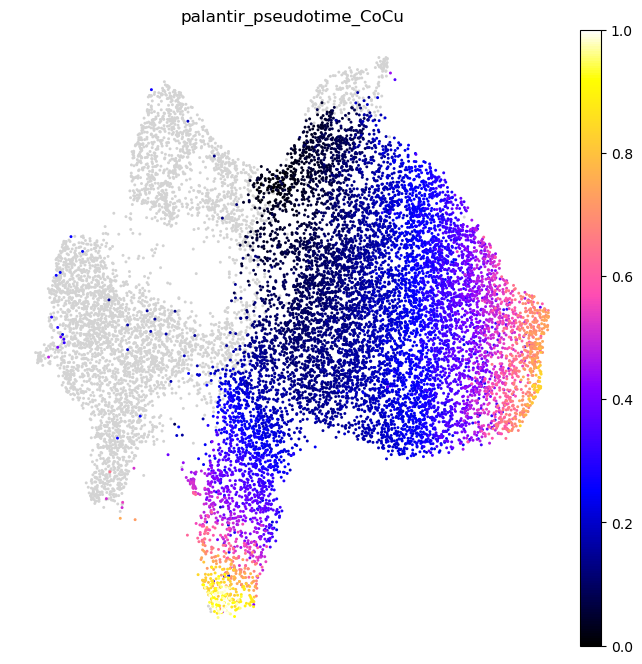

In [31]:
#---------Plotting Pseudotime on Diffusion Map-------#
fig,ax=plt.subplots(figsize=(8, 8))
sc.pl.embedding(Matrix, basis = "X_umap", 
                color = "palantir_pseudotime_CoCu",
                frameon = False,
                cmap = "gnuplot2", 
                ax = ax,
                s = 18)
fig.savefig("/projects/b1217/HHA/Bulb_Seurat_Plots/Figure_6/Palantir/Matrix_CoCu_Pseudotime_UMAP.png",
           dpi = 600, pad_inches = 0.5, bbox_inches = "tight")

In [32]:
#------Saving AnnDatas with Pseudotime-------#
#Full Matrix
Matrix.write_h5ad(os.path.join(ConversionDirectory, "Matrix_Palantir_6_11_25.h5ad"))
#Lower
Matrix_lower.write_h5ad(os.path.join(ConversionDirectory, "Matrix_IRS_Palantir_6_11_25.h5ad"))
#Upper
Matrix_upper.write_h5ad(os.path.join(ConversionDirectory, "Matrix__Cortex_Cuticle_Palantir_6_11_25.h5ad"))